#### Import modules and read data

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from pprint import pprint
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.model_selection import cross_validate, KFold, RepeatedKFold
from sklearn.tree import DecisionTreeClassifier

In [2]:
normal_data = pd.read_csv(os.getcwd() + '/Data/brain_tumour_normalized.csv')
normal_data.head()

,Image,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation,Coarseness,Class
0,Image1,0.194705,0.212023,0.443074,0.274801,0.068211,0.010937,0.028236,0.475410,0.246092,0.603108,0.139694,0.981764,0.0,0
1,Image2,0.261489,0.276124,0.510114,0.674843,0.052278,0.007693,0.017951,0.797096,0.648383,0.773800,0.093527,0.997417,0.0,0
2,Image3,0.219003,0.392326,0.614200,0.001487,0.090618,0.016478,0.023280,0.012719,0.001173,0.230760,0.195261,0.972855,0.0,1
3,Image4,0.177300,0.329007,0.559750,0.001513,0.108202,0.021559,0.043805,0.012908,0.001192,0.196137,0.258588,0.941475,0.0,1
4,Image5,0.218223,0.249840,0.483677,0.370574,0.068403,0.011067,0.050836,0.564860,0.338854,0.560862,0.226679,0.960995,0.0,0


In [3]:
X, Y = normal_data[normal_data.columns[1 : 14]], normal_data[normal_data.columns[-1]]
X.shape, Y.shape

((3762, 13), (3762,))

#### Feature selection using ANOVA F-value

In [4]:
k = 6

feature_selection = SelectKBest(score_func = f_classif, k = k)  # select k best features using ANOVA F-value

fit = feature_selection.fit(X, Y)

In [5]:
pd.DataFrame({'scores': fit.scores_, 'cols': X.columns}).sort_values(by = 'scores', ascending = False).head(k)  # k best features

,scores,cols
7,10913.518208,Energy
9,9587.758475,Homogeneity
3,5772.609943,Entropy
8,5086.027179,ASM
10,1685.254630,Dissimilarity
4,727.528516,Skewness


In [6]:
X_fs = feature_selection.transform(X)
X_fs.shape

(3762, 6)

#### Cross-validation without Feature Selection

In [7]:
def crossVal(model, cv_selected, prt = True):
    scoring = ['accuracy', 'precision', 'recall']  # select metrics
    scores = cross_validate(model, X, Y, scoring = scoring, cv = cv_selected)  # calc scores
    
    if prt:
        print('Test accuracy:', scores['test_accuracy'].mean() * 100)
        print('Test std. dev. of accuracy:', scores['test_accuracy'].std())
        print('-' * 10)
        print('Test sensitivity:', scores['test_recall'].mean() * 100)
        print('Test std. dev. of sensitivity:', scores['test_recall'].std())
        print('-' * 10)
        print('Test precision:', scores['test_precision'].mean() * 100)
        print('Test std. dev. of precision:', scores['test_precision'].std())
    
    return scores['test_accuracy'].mean(), scores['test_recall'].mean(), scores['test_accuracy'].std(), scores['test_recall'].std()

In [8]:
adaBoost = AdaBoostClassifier()  # create standard model

Without repeated folds:

In [9]:
cv = KFold(n_splits = 10, shuffle = True, random_state = 42)  # create CV splits

crossVal(adaBoost, cv)

Test accuracy: 98.61786782549805
Test std. dev. of accuracy: 0.006268334181714131
----------
Test sensitivity: 97.67718381081835
Test std. dev. of sensitivity: 0.014020642062510967
----------
Test precision: 99.21004019232453
Test std. dev. of precision: 0.006596021313716727


(0.9861786782549805,
 0.9767718381081835,
 0.006268334181714131,
 0.014020642062510967)

With repeated folds:

In [10]:
cvr = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 42)  # creates CV splits for repeated KFold CV

crossVal(adaBoost, cvr)

Test accuracy: 98.75058788118216
Test std. dev. of accuracy: 0.0051450117361733485
----------
Test sensitivity: 97.9049444089611
Test std. dev. of sensitivity: 0.010808683837078729
----------
Test precision: 99.29754164092037
Test std. dev. of precision: 0.005643862714722419


(0.9875058788118215,
 0.979049444089611,
 0.0051450117361733485,
 0.010808683837078729)

Notes: Repeated CV gives higher accuracy and sensitivity

#### Feature Selection + Cross-validation

In [11]:
def featSelnCrossVal(model, name, n_splits = 5):
    cv = KFold(n_splits = n_splits, shuffle = True, random_state = 42)  # create CV splits
    
    fig, ax = plt.subplots()
    
    tprs, aucs, mean_fpr = [], [], np.linspace(0, 1, 100)  # true pos rates, area under curves, mean false pos rate
    acc_scores, recall_scores = [], []
    
    for i, (train, test) in enumerate(cv.split(X_fs, Y)):
        model.fit(X_fs[train], Y[train])  # train model
        
        Y_pred = model.predict(X_fs[test])  # get predictions
        
        # calc accuracy and sensitivity
        acc_scores.append(metrics.accuracy_score(Y[test], Y_pred))
        recall_scores.append(metrics.recall_score(Y[test], Y_pred))
        
        vis = metrics.plot_roc_curve(model, X_fs[test], Y[test], name = 'ROC fold {}'.format(i), lw = 1, alpha = 0.3, ax = ax)  # plot ROC curve
    
        interp_tpr = np.interp(mean_fpr, vis.fpr, vis.tpr)  # interpolate true pos rate
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(vis.roc_auc)
        
    ax.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = '#ff0000', label = 'Chance', alpha = 0.5)

    mean_tpr = np.mean(tprs, axis = 0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)  # mean area under curve
    std_auc = np.std(aucs)  # auc std dev
    ax.plot(mean_fpr, mean_tpr, color = '#552583', label = r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc), lw = 2, alpha = 0.8)

    ax.set_title('ROC Curve: {}\nwith feature selection and 5-fold CV'.format(name))
    ax.legend()
    plt.tight_layout()
    plt.savefig(os.getcwd() + '/Graphs/featureSelection/' + name)
    plt.show()
    plt.close()
    
    acc_scores, recall_scores = np.array(acc_scores), np.array(recall_scores)
    print('Test accuracy:', acc_scores.mean() * 100)
    print('Test std. dev. of accuracy:', acc_scores.std())
    print('-' * 10)
    print('Test sensitivity:', recall_scores.mean() * 100)
    print('Test std. dev. of sensitivity:', recall_scores.std())

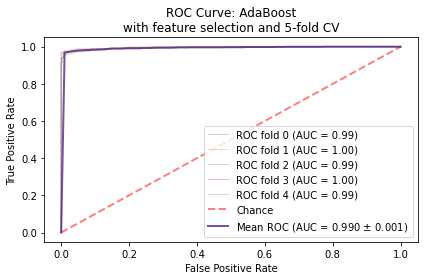

Test accuracy: 97.89985448277811
Test std. dev. of accuracy: 0.0038073928309126574
----------
Test sensitivity: 96.84264481030613
Test std. dev. of sensitivity: 0.006832667312247186


In [12]:
adaBoost = AdaBoostClassifier()

featSelnCrossVal(adaBoost, 'AdaBoost')

Notes: Sensitivity dropped when using X_fs

#### Changing Number of Estimators

10
25
50
100
200
350


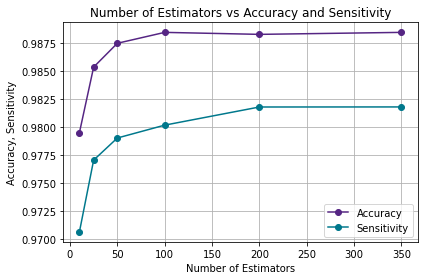

Overall highest accuracy: 98.84803506593674
Corresponding sensitivity: 98.01980363662001
Corresponding number of estimators: 100
----------
Overall highest sensitivity: 98.1824079816268
Corresponding accuracy: 98.84803506593674
Corresponding number of estimators: 350
----------
[10, 25, 50, 100, 200, 350]
[0.9795306826946591, 0.9853786895422991, 0.9875058788118215, 0.9884803506593675, 0.9883028105423555, 0.9884803506593675]
[0.9706743107470729, 0.9770754367900238, 0.979049444089611, 0.9801980363662001, 0.9818181262229478, 0.981824079816268]


In [17]:
# n_estim = [10, 25, 50, 100, 500, 1000]  # too slow after 100
n_estim = [10, 25, 50, 100, 200, 350]
acc_mean, recall_mean, acc_std, recall_std = [], [], [], []

cvr = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 42)  # creates CV splits for repeated KFold CV

for i in n_estim:
    print(i)
    
    adaBoost_estim = AdaBoostClassifier(n_estimators = i)  # create model
    
    acc, rec, acc_dev, rec_dev = crossVal(adaBoost_estim, cvr, prt = False)
    
    acc_mean.append(acc)
    recall_mean.append(rec)
    acc_std.append(acc_dev)
    recall_std.append(rec_dev)
    
plt.plot(n_estim, acc_mean, color = '#552583', marker = 'o', label = 'Accuracy')
plt.plot(n_estim, recall_mean, color = '#00788c', marker = 'o', label = 'Sensitivity')
plt.grid()
plt.legend()
plt.title('Number of Estimators vs Accuracy and Sensitivity')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy, Sensitivity')
plt.tight_layout()
plt.savefig(os.getcwd() + '/Graphs/adaBoost/adaBoostEstimators')
plt.show()
plt.close()

acc_scores, recall_scores = np.array(acc_mean), np.array(recall_mean)

max_idx = acc_scores.argmax()
print('Overall highest accuracy:', acc_scores[max_idx] * 100)
print('Corresponding sensitivity:', recall_scores[max_idx] * 100)
print('Corresponding number of estimators:', n_estim[max_idx])
print('-' * 10)
max_idx = recall_scores.argmax()
print('Overall highest sensitivity:', recall_scores[max_idx] * 100)
print('Corresponding accuracy:', acc_scores[max_idx] * 100)
print('Corresponding number of estimators:', n_estim[max_idx])
print('-' * 10)
print(n_estim)
print(acc_mean)
print(recall_mean)

The models with 200 and 350 estimators have the same performance, but the latter takes longer to train. Hence, we will proceed with 200 estimators.

#### Changing Ensemble Learner

In [14]:
n_estim = [50, 200]  # scikit-learn 0.23.2 default no. of estimators for AdaBoostClassifier is 50
depths = [1, 6, 15]  # decision trees of depth 6 and 15 performed well, 1 is default
acc_mean, recall_mean, acc_std, recall_std = [], [], [], []

cvr = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 42)  # creates CV splits for repeated KFold CV

for n in n_estim:
    acc_at_n, rec_at_n, acc_dev_at_n, rec_dev_at_n = [], [], [], []  # accuracy and recall at current n
    
    for depth in depths:
        print(n, depth)
        
        base_tree = DecisionTreeClassifier(criterion = 'gini', max_depth = depth)  # base estimator

        adaBoost_estim_depth = AdaBoostClassifier(base_estimator = base_tree, n_estimators = n)  # create model
        
        acc, rec, acc_dev, rec_dev = crossVal(adaBoost_estim_depth, cvr, prt = False)
        
        acc_at_n.append(acc)
        rec_at_n.append(rec)
        acc_dev_at_n.append(acc_dev)
        rec_dev_at_n.append(rec_dev)
        
    acc_mean.append(acc_at_n)
    recall_mean.append(rec_at_n)
    acc_std.append(acc_dev_at_n)
    recall_std.append(rec_dev_at_n)

print('Accuracy:')
pprint(acc_mean)
print('Accuracy std. dev.:')
pprint(acc_std)
print('-' * 10)
print('Sensitivity:')
pprint(recall_mean)
print('Sensitivity std. dev.:')
pprint(recall_std)

50 1
50 6
50 15
200 1
200 6
200 15
Accuracy:
[[0.9875058788118215, 0.9904302349643507, 0.9836961735989612],
 [0.9883028105423555, 0.9916708994111779, 0.9840512538329853]]
Accuracy std. dev.:
[[0.0051450117361733485, 0.004634711975067397, 0.007021576454107933],
 [0.004788473734367967, 0.004326611751159085, 0.00709687046818189]]
----------
Sensitivity:
[[0.979049444089611, 0.9822607961531349, 0.9789985308989898],
 [0.9818181262229478, 0.9826886217195467, 0.9780486107150393]]
'Sensitivity std. dev.:'
[[0.010808683837078729, 0.008971976588657631, 0.011174277500526133],
 [0.008920908721984868, 0.00890577086281257, 0.011194073445776996]]


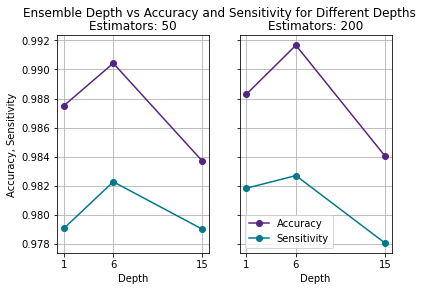

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True)
fig.suptitle('Ensemble Depth vs Accuracy and Sensitivity for Different Depths')

ax1.plot(depths, acc_mean[0], color = '#552583', marker = 'o', label = 'Accuracy')
ax1.plot(depths, recall_mean[0], color = '#00788c', marker = 'o', label = 'Sensitivity')
ax1.grid()
ax1.set_title('Estimators: {}'.format(n_estim[0]))
ax1.set_xlabel('Depth')
ax1.set_ylabel('Accuracy, Sensitivity')
ax1.set_xticks(depths)
ax2.plot(depths, acc_mean[1], color = '#552583', marker = 'o', label = 'Accuracy')
ax2.plot(depths, recall_mean[1], color = '#00788c', marker = 'o', label = 'Sensitivity')
ax2.grid()
ax2.set_title('Estimators: {}'.format(n_estim[1]))
ax2.set_xlabel('Depth')
ax2.set_xticks(depths)
plt.legend()
# plt.tight_layout()
plt.savefig(os.getcwd() + '/Graphs/adaBoost/adaBoostEstimatorsDepth')
plt.show()
plt.close()

In [37]:
for i in range(len(n_estim)):
    print('Number of Estimators:', n_estim[i])
    print('\n')
    max_idx = acc_scores[i].argmax()
    print('Overall highest accuracy:', acc_scores[i][max_idx] * 100)
    print('Corresponding sensitivity:', recall_scores[i][max_idx] * 100)
    print('Corresponding decision tree depth:', depths[max_idx])
    print('-' * 10)
    max_idx = recall_scores[i].argmax()
    print('Overall highest sensitivity:', recall_scores[i][max_idx] * 100)
    print('Corresponding accuracy:', acc_scores[i][max_idx] * 100)
    print('Corresponding decision tree depth:', depths[max_idx])
    print('-' * 20)

Number of Estimators: 50


Overall highest accuracy: 99.04302349643507
Corresponding sensitivity: 98.2260796153135
Corresponding decision tree depth: 6
----------
Overall highest sensitivity: 98.2260796153135
Corresponding accuracy: 99.04302349643507
Corresponding decision tree depth: 6
--------------------
Number of Estimators: 200


Overall highest accuracy: 99.1670899411178
Corresponding sensitivity: 98.26886217195468
Corresponding decision tree depth: 6
----------
Overall highest sensitivity: 98.26886217195468
Corresponding accuracy: 99.1670899411178
Corresponding decision tree depth: 6
--------------------


Notes: The model with 200 estimators and depth 6 has higher accuracy and sensitivity. It performs better than the adaBoost_estim model too.